In [25]:
using Revise
using FUSE
using Plots;
FUSE.logging(Logging.Info; actors=Logging.Info);


In [26]:
# sty is the act equivalent for a study, it has common parameters like server and n_workers but also study dependent parameters like TGLF saturation rules
sty,act = FUSE.study_parameters(:TGLFdb);
sty

ParametersStudyTGLFdb{Real}
├─ server{String} ➡ "localhost" Where to run ["localhost", "omega", "saga"]
├─ n_workers{Int64} ➡ missing Number of workers to run with
├─ file_save_mode{Symbol} ➡ :safe_write Saving file policy, `safe_write` only writes when the folder is empty [:safe_write,
│  :overwrite]
├─ release_workers_after_run{Bool} ➡ true Releases the workers after running the study
├─ save_dd{Bool} ➡ true Save dd of the study to save folder
├─ sat_rules{Vector{Symbol}} ➡ missing TGLF saturation rules to run
├─ lump_ions{Bool} ➡ true Lumps the fuel species (D,T) as well as the impurities together
├─ custom_tglf_models{Vector{String}} ➡ missing This will run custom TGLFNN models stored in TGLFNN/models
├─ save_folder{String} ➡ missing Folder to save the database runs into
└─ database_folder{String} ➡ missing Folder with input database


In [27]:
# Interacting with sty
sty.server = "saga"
sty.n_workers = 2

sty.database_folder = "/mnt/beegfs/users/neisert/ODSs/iri/full_166066" #166066" #mastu_test" #d3d_negDcake_oak"#"/mnt/beegfs/users/neisert/ODSs/mastu"

sty.save_folder = "/mnt/beegfs/users/neisert/ODSs/iri/full_166066/outputs_rerun2_rho_0p1_0p05_0p85_rot" #"/mnt/beegfs/users/neisert/ODSs/mastu/outputs_sat1_es_d3d"
sty.sat_rules = missing #[:sat2]#,:sat1,:sat2,:sat3] #study specific parameters
# It's also possible to run with a custom tglfnn model, set sty.custom_tglf_models
sty.custom_tglf_models = ["sat1_em_d3d"]
sty.file_save_mode = :overwrite
sty.release_workers_after_run = true # this is the default behavior and releases workers after running the study
sty

ParametersStudyTGLFdb{Real}
├─ server{String} ➡ "saga" Where to run ["localhost", "omega", "saga"]
├─ n_workers{Int64} ➡ 2 Number of workers to run with
├─ file_save_mode{Symbol} ➡ :overwrite Saving file policy, `safe_write` only writes when the folder is empty [:safe_write,
│  :overwrite]
├─ release_workers_after_run{Bool} ➡ true Releases the workers after running the study
├─ save_dd{Bool} ➡ true Save dd of the study to save folder
├─ sat_rules{Vector{Symbol}} ➡ missing TGLF saturation rules to run
├─ lump_ions{Bool} ➡ true Lumps the fuel species (D,T) as well as the impurities together
├─ custom_tglf_models{Vector{String}} ➡ ["sat1_em_d3d"] This will run custom TGLFNN models stored in TGLFNN/models
├─ save_folder{String} ➡ "/mnt/beegfs/users/neisert/ODSs/iri/full_166066/outputs_rerun2_rho_0p1_0p05_0p85_rot" Folder to
│  save the database runs into
└─ database_folder{String} ➡ "/mnt/beegfs/users/neisert/ODSs/iri/full_166066" Folder with input database


In [28]:
# study is the actor equivalent of actors, here sty, act and outputs are kept of the workflow
study = FUSE.StudyTGLFdb(sty, act; n_workers=2); # it is possible to pass in keyword arguments to sty

# instantiating the study will also setup the study i.e. FUSE.setup(study);

LoadError: ArgumentError: invalid base 10 digit 'C' in "12C6"

In [30]:
# for now you will have to import FUSE everywhere in your distributed computing
using Distributed
@everywhere import FUSE


In [31]:
study.act.ActorFluxMatcher.evolve_rotation = :flux_match
study.act.ActorFluxMatcher.rho_transport = 0.1:0.05:0.85
# density is evolved now by default with impurities fixed
#=study.act.ActorFluxMatcher.evolve_densities = Dict(
    :D        => :quasi_neutrality,
    :D_fast   => :fixed,
    :C        => :fixed,
    :electrons => :flux_match)
=#
study.act.ActorFluxMatcher

ActorFluxMatcher{Float64}
├─ rho_transport{AbstractVector{Float64}} ➡ 0.1:0.05:0.85 ρ transport grid
├─ evolve_Ti{Symbol} ➡ :flux_match Ion temperature `:flux_match` or keep `:fixed` [:flux_match, :fixed]
├─ evolve_Te{Symbol} ➡ :flux_match Electron temperature `:flux_match` or keep `:fixed` [:flux_match, :fixed]
├─ evolve_densities{Union{Symbol, AbstractDict}} ➡ :fixed Densities `:fixed`, or electron flux-match and rest match ne
│  scale `:flux_match`, or Dict to specify which species are `:flux_match`, kept `:fixed`, used to enforce
│  `:quasi_neutrality`, or scaled to `:match_ne_scale`
├─ evolve_rotation{Symbol} ➡ :flux_match Rotation `:flux_match` or keep `:fixed` [:flux_match, :fixed]
├─ evolve_pedestal{Bool} ➡ false Evolve the pedestal inside the transport solver
├─ find_widths{Bool} ➡ true Runs Turbulent transport actor TJLF finding widths after first iteration
├─ max_iterations{Int64} ➡ 300 Maximum optimizer iterations
├─ optimizer_algorithm{Symbol} ➡ :anderson Optimizing algori

In [32]:
FUSE.run(study);   # runs the study, this also writes the dataframes

# at the end of the run workers are released so you will have to setup again if you want to run more

LoadError: AssertionError: The number of workers =  1 isn't the number of workers you requested = 2

In [23]:
# data for this workflow is stored in a dictionary of dataframes study.dataframes_dict
#study.dataframes_dict[:sat1]
#study.dataframes_dict["sat1_es_d3d"]

study.dataframes_dict["sat1_em_d3d"]# "sat3_em_d3d_azf1"]

Row,shot,time,ne0,Te0,Ti0,ne0_exp,Te0_exp,Ti0_exp,WTH_exp,rot0_exp,WTH,rot0,rho,Qe_target,Qe_TGLF,Qe_neoc,Qi_target,Qi_TGLF,Qi_neoc,particle_target,particle_TGLF,particle_neoc,momentum_target,momentum_TGLF,Q_GB,particle_GB,momentum_GB
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…,Array…
1,166066,1100,4.94411e19,3223.43,3376.71,3.26394e19,2789.86,3883.31,2.54674e5,1.08486e5,3.19864e5,1.51324e5,"[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]","[8802.32, 14507.6, 24244.0, 19336.3, 27028.2, 29752.8, 28876.7, 30767.0, 29917.8, 35992.4, 37980.0, 38809.0, 40925.8, 42273.3, 44244.0, 42990.3]","[6618.59, 13365.0, 23543.7, 18909.3, 26726.6, 29551.2, 28737.4, 30663.6, 29840.2, 35926.8, 37923.4, 38758.4, 40877.3, 42223.1, 44189.6, 42930.9]","[2183.73, 1142.63, 700.313, 427.028, 301.573, 201.616, 139.286, 103.399, 77.5419, 65.623, 56.5465, 50.5743, 48.4912, 50.261, 54.3626, 59.4631]","[24324.7, 31692.1, 55849.6, 36951.7, 60028.4, 59968.3, 55074.6, 56807.6, 53228.8, 61160.6, 61348.1, 59491.4, 59256.1, 54587.9, 55149.8, 55206.0]","[714.966, 12865.0, 42027.2, 28141.2, 53941.0, 55888.3, 52272.4, 54753.8, 51712.1, 59943.6, 60348.3, 58628.5, 58469.6, 53863.8, 54450.5, 54512.9]","[23609.8, 18827.1, 13822.4, 8810.5, 6087.4, 4079.94, 2802.2, 2053.86, 1516.69, 1217.01, 999.859, 862.853, 786.505, 724.079, 699.275, 693.115]","[2.99721e18, 4.10177e18, 1.29599e19, 2.88592e18, 1.11491e19, 1.17778e19, 8.83043e18, 8.88998e18, 6.16114e18, 9.90071e18, 9.91405e18, 9.44807e18, 9.78539e18, 9.7176e18, 1.09267e19, 1.27402e19]","[1.22373e18, 3.08581e18, 1.22704e19, 2.48031e18, 1.08402e19, 1.15601e19, 8.67415e18, 8.76704e18, 6.06537e18, 9.81237e18, 9.83053e18, 9.36338e18, 9.69105e18, 9.60147e18, 1.0777e19, 1.25272e19]","[1.77348e18, 1.01596e18, 6.8947e17, 4.05607e17, 3.08869e17, 2.17747e17, 1.56288e17, 1.2294e17, 9.5775e16, 8.83466e16, 8.35219e16, 8.46928e16, 9.43442e16, 1.16134e17, 1.49765e17, 2.12938e17]","[0.0281162, 0.0423968, 0.079564, 0.051105, 0.0785593, 0.0764692, 0.0713478, 0.073296, 0.070853, 0.0806166, 0.0816966, 0.0771689, 0.0820108, 0.0809449, 0.0750871, 0.0903418]","[0.0281162, 0.0423968, 0.079564, 0.051105, 0.0785593, 0.0764692, 0.0713478, 0.073296, 0.070853, 0.0806166, 0.0816966, 0.0771689, 0.0820108, 0.0809449, 0.0750871, 0.0903418]","[185745.0, 1.5058e5, 1.19913e5, 92887.1, 70153.1, 51954.9, 38487.0, 28351.0, 20453.8, 14708.1, 10202.2, 6925.51, 4530.09, 2780.69, 1540.59, 660.386]","[3.83831e20, 3.32893e20, 2.84617e20, 2.38604e20, 1.97273e20, 1.60853e20, 1.31489e20, 1.07148e20, 8.5678e19, 6.8545e19, 5.32447e19, 4.07379e19, 3.02932e19, 2.14861e19, 1.4146e19, 7.78059e18]","[0.290714, 0.243766, 0.201141, 0.162089, 0.128084, 0.0995327, 0.077453, 0.0600086, 0.0455783, 0.0345703, 0.0253759, 0.0182878, 0.0127545, 0.00841571, 0.00508271, 0.00246794]"
2,166066,1200,7.69856e19,3238.69,3755.11,3.64455e19,2920.06,4674.69,5.04736e5,1.42966e5,6.09266e5,1.49857e5,"[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]","[6063.05, 20834.4, 29873.2, 31203.6, 25005.0, 26074.9, 27242.5, 28732.1, 31265.0, 33814.3, 33877.7, 39131.3, 41281.8, 43712.6, 42713.5, 37635.3]","[3391.17, 17953.6, 28082.6, 30140.7, 24367.4, 25681.9, 26965.2, 28533.2, 31107.4, 33684.3, 33768.6, 39026.5, 41174.4, 43595.9, 42591.3, 37502.0]","[2671.87, 2880.78, 1790.62, 1062.91, 637.585, 392.968, 277.378, 198.867, 157.665, 130.087, 109.066, 104.811, 107.374, 116.647, 122.154, 133.252]","[17061.3, 18401.7, 28308.2, 37570.8, 32080.4, 46699.2, 52074.8, 50311.0, 54843.6, 59693.6, 58469.2, 63185.8, 61182.9, 58982.9, 59321.0, 41072.5]","[-6187.5, -9074.33, 3741.12, 20215.0, 20841.7, 38161.7, 46506.1, 46128.6, 51915.8, 57432.6, 56538.4, 61428.8, 59475.7, 57279.5, 57575.0, 38753.4]","[23248.8, 27476.0, 24567.1, 17355.8, 11238.6, 8537.51, 5568.74, 4182.42, 2927.82, 2261.04, 1930.8, 1756.94

MRE SAT1 EM D3D W_thermal = 5.25 % with N = 39


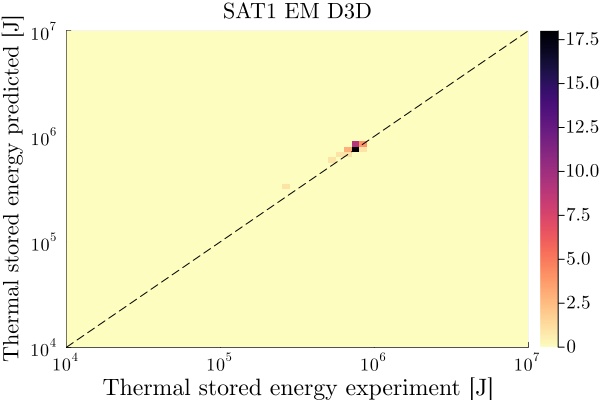

In [24]:
# analyze the study results 
FUSE.analyze(study);